In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pickle
import math
from bidict import bidict
from tqdm import tqdm
from utils.dataset import generate_dataset
from utils.Profiler import Profiler
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from SequentialGroup import Column, Group, Node, Link



In [2]:
def plot_curve(y, color='#1F77B4', color2="#82B0D2", window_size = 1000, y_bottom=None, y_top=None, label=None):
    s = pd.Series(y)
    s_ma = s.rolling(window=window_size, min_periods=1).mean()
    upper_quartile = s.rolling(window=window_size, min_periods=1).quantile(0.75)
    lower_quartile = s.rolling(window=window_size, min_periods=1).quantile(0.25)
    plt.plot(s, c=color2, alpha=0.3, zorder=2)
    plt.fill_between(s.index, lower_quartile, upper_quartile, color=color2, zorder=4)
    plt.plot(s_ma, color=color, label=label, zorder=6)
    plt.ylim(bottom=y_bottom, top=y_top)

In [3]:
seq1 = ['A', 'B', 'C', 'D']
seq2 = ['X', 'B', 'C', 'Y']
seqs = [seq1, seq2]

D_train, _, dictionary = generate_dataset(seqs)
data = D_train[:5000]

In [4]:
data_ = torch.tensor(data)


In [5]:
embeddings = np.random.uniform(-1, 1, size=(27, 32))
mapping = dict({i: embeddings[i] for i in range(len(embeddings))})

## LSTM

In [6]:
class SeL_LSTM(nn.Module):
    def __init__(self, embeddings: torch.Tensor, num_layers, hidden_size, seq_length, dropout=0.1):
        super(SeL_LSTM, self).__init__()
        self.seq_length = seq_length
        
        embed = torch.FloatTensor(embeddings)
        self.embedding = nn.Embedding(num_embeddings=embed.shape[0], embedding_dim=embed.shape[1], _weight=embed)
        
        self.lstm = nn.LSTM(input_size=embed.shape[1], hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.Linear(hidden_size, embed.shape[0])

    def forward(self, src):
        src = self.embedding(src)
        lstm_out, _ = self.lstm(src)
        output = self.decoder(lstm_out[:, -1, :])
        return output

In [7]:
num_layers = 2
num_heads = 4
seq_length = 4
dropout = 0.1

# Initialize model, loss function, and optimizer
model = SeL_LSTM(embeddings, num_layers, num_heads, seq_length, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
losses = []
accuracies1 = []
profiler = Profiler(100)
n_span = seq_length
topk = 1
for i in tqdm(range(n_span, len(data_))):
    src, tgt = data_[i-n_span:i], data_[i:i+1]

    optimizer.zero_grad()
    pred: torch.Tensor = model(src.unsqueeze(0))
    loss = criterion(pred.view(-1, pred.shape[-1]), tgt.view(-1))
    # loss = criterion(output, tgt.unsqueeze(0))
    loss.backward()
    optimizer.step()


    losses.append(float(loss))
    if i%100 == 0:
        print(losses[-1])

    # labels = torch.argmax(pred.detach(), dim=-1)
    _, labels = torch.topk(pred.detach(), topk)
    anticipations = set(labels.squeeze(0).tolist())
    acc = profiler.observe(anticipations, int(tgt))
    
    accuracies1.append(float(acc))


  6%|▌         | 280/4996 [00:00<00:04, 985.40it/s]

3.265279769897461
3.002615213394165
3.574892520904541


 12%|█▏        | 612/4996 [00:00<00:04, 1069.49it/s]

3.3355865478515625
2.7635154724121094
2.4440293312072754


 17%|█▋        | 832/4996 [00:00<00:03, 1085.62it/s]

4.222622871398926
2.3370449542999268
3.441849708557129


 23%|██▎       | 1168/4996 [00:01<00:03, 1107.74it/s]

3.6390647888183594
1.9618010520935059


 28%|██▊       | 1389/4996 [00:01<00:03, 1042.20it/s]

2.2995352745056152
3.518545627593994
1.7327470779418945


 32%|███▏      | 1598/4996 [00:01<00:03, 977.67it/s] 

2.1720080375671387
3.9865355491638184


 36%|███▋      | 1812/4996 [00:01<00:03, 1021.91it/s]

1.4838166236877441
2.1369080543518066
3.3003597259521484


 43%|████▎     | 2151/4996 [00:02<00:02, 1092.47it/s]

1.5527334213256836
1.4967215061187744
4.081755638122559


 49%|████▉     | 2465/4996 [00:02<00:02, 996.73it/s] 

1.3109769821166992
2.59220027923584
3.1001765727996826


 56%|█████▌    | 2785/4996 [00:02<00:02, 1039.07it/s]

1.1518573760986328
1.9287902116775513
2.7263145446777344


 62%|██████▏   | 3119/4996 [00:03<00:01, 1087.90it/s]

1.055802822113037
1.445198893547058
3.398170232772827


 67%|██████▋   | 3339/4996 [00:03<00:01, 1092.65it/s]

1.061413288116455
1.2915961742401123
3.7419443130493164


 73%|███████▎  | 3670/4996 [00:03<00:01, 1091.60it/s]

1.0355991125106812
1.377833604812622
3.485081911087036


 80%|████████  | 3998/4996 [00:03<00:00, 1087.48it/s]

0.9406781196594238
1.711766004562378
3.752100944519043


 84%|████████▍ | 4215/4996 [00:04<00:00, 1071.55it/s]

0.8985412120819092
1.588484525680542
3.1085128784179688


 91%|█████████ | 4543/4996 [00:04<00:00, 1082.92it/s]

0.8700218796730042
1.2694809436798096
3.5605010986328125


 97%|█████████▋| 4871/4996 [00:04<00:00, 1085.10it/s]

0.8552218079566956
3.109915018081665
2.8765807151794434


100%|██████████| 4996/4996 [00:04<00:00, 1055.36it/s]


Text(0.5, 0, 'event')

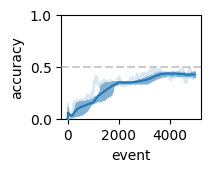

In [9]:
plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve(accuracies1[:50000], y_bottom=0, y_top=1, label="all")
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
# plot_curve(accuracies1_2[:50000], color="#2CA02C", color2="#8ECFC9", y_bottom=0, y_top=1, label="Top1")
# plt.legend(loc='upper right')
plt.ylabel("accuracy")
plt.xlabel("event")

## Transformer

In [10]:

class SeL_Transformer(nn.Module):
    def __init__(self, embeddings: torch.Tensor, num_layers, num_heads, seq_length, dropout=0.1):
        super(SeL_Transformer, self).__init__()
        self.seq_length = seq_length
        
        hidden_size = embeddings.shape[1]
        
        embed = torch.FloatTensor(embeddings)
        self.embedding = nn.Embedding(num_embeddings=embed.shape[0], embedding_dim=embed.shape[1], _weight=embed)
        
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, hidden_size))
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_size, embed.shape[0])

    def forward(self, src):
        src = self.embedding(src) + self.positional_encoding[:, :self.seq_length, :]
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])
        return output

In [11]:
num_layers = 2
num_heads = 4
seq_length = 4
dropout = 0.1

# Initialize model, loss function, and optimizer
model = SeL_Transformer(embeddings, num_layers, num_heads, seq_length, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/opt/homebrew/Caskroom/miniforge/base/envs/PyNARS/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [12]:
losses = []
accuracies2 = []
profiler = Profiler(100)
n_span = seq_length
topk = 1
for i in tqdm(range(n_span, len(data_))):
    src, tgt = data_[i-n_span:i], data_[i:i+1]

    optimizer.zero_grad()
    pred: torch.Tensor = model(src.unsqueeze(0))
    loss = criterion(pred.view(-1, pred.shape[-1]), tgt.view(-1))
    # loss = criterion(output, tgt.unsqueeze(0))
    loss.backward()
    optimizer.step()


    losses.append(float(loss))
    if i%100 == 0:
        print(losses[-1])

    # labels = torch.argmax(pred.detach(), dim=-1)
    _, labels = torch.topk(pred.detach(), topk)
    anticipations = set(labels.squeeze(0).tolist())
    acc = profiler.observe(anticipations, int(tgt))
    
    accuracies2.append(float(acc))


  2%|▏         | 107/4996 [00:01<00:52, 93.60it/s]

4.541497230529785


  4%|▍         | 207/4996 [00:02<00:48, 98.14it/s] 

0.4896186292171478


  6%|▌         | 305/4996 [00:03<00:47, 99.55it/s]

1.3313881158828735


  8%|▊         | 412/4996 [00:04<00:48, 94.86it/s]

5.185905456542969


 10%|█         | 509/4996 [00:05<00:44, 100.85it/s]

0.09264709800481796


 12%|█▏        | 607/4996 [00:06<00:47, 93.33it/s] 

1.9022877216339111


 14%|█▍        | 714/4996 [00:07<00:47, 90.76it/s] 

3.8553550243377686


 16%|█▌        | 808/4996 [00:08<00:59, 70.74it/s]

0.10513705760240555


 18%|█▊        | 909/4996 [00:10<00:44, 92.74it/s]

3.549189567565918


 20%|██        | 1012/4996 [00:11<00:43, 90.69it/s]

3.5181901454925537


 22%|██▏       | 1113/4996 [00:12<00:36, 105.72it/s]

0.09544739127159119


 24%|██▍       | 1214/4996 [00:13<00:37, 101.84it/s]

1.2550022602081299


 26%|██▌       | 1307/4996 [00:14<00:44, 83.50it/s] 

2.9497251510620117


 28%|██▊       | 1410/4996 [00:15<00:34, 102.87it/s]

0.0859411358833313


 30%|███       | 1512/4996 [00:16<00:37, 92.59it/s] 

1.1913247108459473


 32%|███▏      | 1605/4996 [00:17<00:38, 87.89it/s]

3.7453556060791016


 34%|███▍      | 1707/4996 [00:18<00:35, 91.93it/s]

0.06889503449201584


 36%|███▋      | 1815/4996 [00:19<00:36, 87.95it/s]

1.840395212173462


 38%|███▊      | 1913/4996 [00:21<00:32, 95.43it/s]

3.6385109424591064


 40%|████      | 2011/4996 [00:22<00:34, 86.93it/s]

0.03568538278341293


 42%|████▏     | 2107/4996 [00:23<00:31, 92.40it/s]

1.5171757936477661


 44%|████▍     | 2213/4996 [00:24<00:32, 86.79it/s]

3.921816825866699


 46%|████▌     | 2301/4996 [00:26<00:48, 55.33it/s]

0.1079217940568924


 48%|████▊     | 2407/4996 [00:28<00:44, 58.52it/s]

1.3798774480819702


 50%|█████     | 2510/4996 [00:29<00:27, 89.13it/s]

3.794611930847168


 52%|█████▏    | 2610/4996 [00:30<00:24, 98.60it/s] 

0.17078126966953278


 54%|█████▍    | 2715/4996 [00:31<00:24, 92.71it/s] 

2.349856376647949


 56%|█████▋    | 2813/4996 [00:32<00:18, 119.62it/s]

3.30090069770813


 58%|█████▊    | 2909/4996 [00:33<00:21, 98.51it/s] 

0.06682232022285461


 60%|██████    | 3012/4996 [00:34<00:22, 89.44it/s]

1.171188473701477


 62%|██████▏   | 3106/4996 [00:35<00:20, 91.15it/s]

3.5604803562164307


 64%|██████▍   | 3205/4996 [00:36<00:20, 88.14it/s] 

0.06347965449094772


 66%|██████▌   | 3305/4996 [00:38<00:18, 90.75it/s]

1.0852173566818237


 68%|██████▊   | 3409/4996 [00:39<00:21, 75.33it/s]

3.5129318237304688


 70%|███████   | 3508/4996 [00:40<00:19, 78.25it/s]

0.07379980385303497


 72%|███████▏  | 3606/4996 [00:41<00:16, 85.28it/s]

1.3780862092971802


 74%|███████▍  | 3710/4996 [00:42<00:13, 98.41it/s]

4.03179931640625


 76%|███████▌  | 3803/4996 [00:43<00:12, 94.84it/s] 

0.07709717005491257


 78%|███████▊  | 3906/4996 [00:44<00:11, 91.00it/s] 

1.5188207626342773


 80%|████████  | 4010/4996 [00:46<00:12, 82.08it/s] 

3.956770896911621


 82%|████████▏ | 4103/4996 [00:47<00:10, 87.07it/s]

0.03919454291462898


 84%|████████▍ | 4212/4996 [00:48<00:10, 74.23it/s]

1.354323148727417


 86%|████████▌ | 4306/4996 [00:50<00:09, 76.06it/s]

3.1489672660827637


 88%|████████▊ | 4405/4996 [00:51<00:08, 73.71it/s]

0.054835814982652664


 90%|█████████ | 4511/4996 [00:53<00:06, 77.76it/s]

4.4622416496276855


 92%|█████████▏| 4600/4996 [00:54<00:04, 79.45it/s]

3.818843126296997


 94%|█████████▍| 4711/4996 [00:55<00:03, 90.94it/s]

0.04180394858121872


 96%|█████████▌| 4800/4996 [00:56<00:02, 75.24it/s]

3.497833490371704


 98%|█████████▊| 4911/4996 [00:58<00:01, 70.72it/s]

3.2067909240722656


100%|██████████| 4996/4996 [00:59<00:00, 83.47it/s]


Text(0.5, 0, 'event')

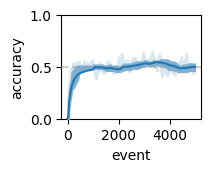

In [13]:
plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve(accuracies2[:50000], y_bottom=0, y_top=1, label="all")
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
# plot_curve(accuracies1_2[:50000], color="#2CA02C", color2="#8ECFC9", y_bottom=0, y_top=1, label="Top1")
# plt.legend(loc='upper right')
plt.ylabel("accuracy")
plt.xlabel("event")

## SeL-NAL

In [14]:
def create_model(n_columns, n_nodes):
    # Create the model
    g = Group(n_columns, n_nodes)
    g.thresh = 0.8
    g.p_plus = 2 #1.95
    g.p_minus = 0.99 #0.9
    g.p_minus2 = 0.01

    for idx, column in enumerate(g.columns):
        column.mark = idx
    return g

def test_model(g: Group, data, top1=False):
    print(len(data))
    print(data[:20])
    accuracies = []
    n_anticipations = []

    profiler = Profiler(100)
    for i, (idx, idx_next) in enumerate((tqdm(zip(data[:-1], data[1:]), total=len(data)-1))):
        candidates: set[Node] = g.activate(idx)
        anticipations = set()
        if not top1:
            for candidate in candidates:
                anticipations.add(candidate.column.mark)
        else:
            if len(candidates) > 0:
                candidate = max(candidates, key=lambda node: node.activity_pred)
                anticipations.add(candidate.column.mark)

        ''' compute the accuracy '''
        acc = profiler.observe(anticipations, idx_next)
        accuracies.append(acc)
        ''' count the number of valid anticipations '''
        a = np.array(g.columns[idx].get_activities(), dtype=bool)
        if not all(a):
            n_anticipations.append((len(anticipations), sum(a)))
        # n_anticipations.append(len(anticipations))
        
    return accuracies, g, n_anticipations

In [15]:
g1 = create_model(26, 10)
accuracies3, _, _ = test_model(g1, data, top1=True)

5000
[0, 3, 2, 1, 6, 13, 5, 3, 2, 4, 16, 11, 0, 3, 2, 1, 1, 9, 0, 3]


100%|██████████| 4999/4999 [00:00<00:00, 9751.59it/s] 


Text(0.5, 0, 'event')

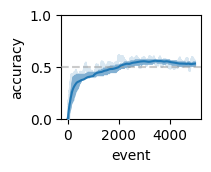

In [16]:
plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve(accuracies3[:50000], y_bottom=0, y_top=1, label="all")
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("accuracy")
plt.xlabel("event")

## Compare

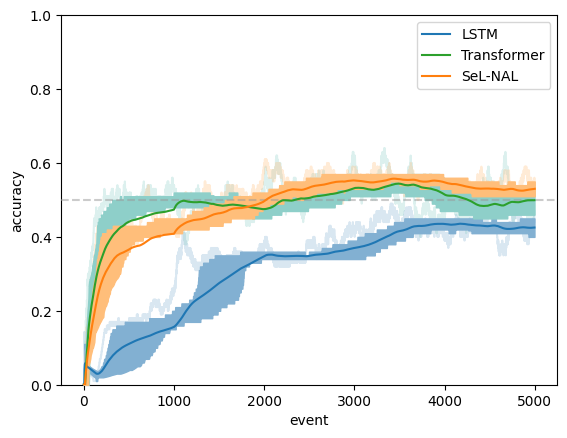

In [17]:
plt.figure()
# plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve(accuracies1[:50000], color='#1F77B4', color2="#82B0D2", y_bottom=0, y_top=1, label="LSTM")
plot_curve(accuracies2[:50000], color="#2CA02C", color2="#8ECFC9", y_bottom=0, y_top=1, label="Transformer")
plot_curve(accuracies3[:50000], color="#FF7F0E", color2="#FFBE7A", y_bottom=0, y_top=1, label="SeL-NAL")
plt.legend()
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("accuracy")
plt.xlabel("event")
plt.savefig("Figures/compare.pdf")